## Setup

Import necessary modules

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import Dataset

We create our own datasets for different fruits, animals and limbs. dataset uploaded on google drive in zip format.

In [2]:
# Download dataset from google drive
! gdown --id 11Krasc-EOa3VKkLZd9JGQpLMu8M8uFQV

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11Krasc-EOa3VKkLZd9JGQpLMu8M8uFQV
To: /content/sound-fix.zip
100% 65.8M/65.8M [00:00<00:00, 132MB/s]


In [3]:
# Unzip the folder
! unzip sound-fix.zip

Archive:  sound-fix.zip
   creating: sound-fix/apel/
  inflating: sound-fix/apel/Perekaman baru 1.wav  
  inflating: sound-fix/apel/Perekaman baru 10.wav  
  inflating: sound-fix/apel/Perekaman baru 11.wav  
  inflating: sound-fix/apel/Perekaman baru 12.wav  
  inflating: sound-fix/apel/Perekaman baru 13.wav  
  inflating: sound-fix/apel/Perekaman baru 14.wav  
  inflating: sound-fix/apel/Perekaman baru 15.wav  
  inflating: sound-fix/apel/Perekaman baru 16.wav  
  inflating: sound-fix/apel/Perekaman baru 17.wav  
  inflating: sound-fix/apel/Perekaman baru 18.wav  
  inflating: sound-fix/apel/Perekaman baru 19.wav  
  inflating: sound-fix/apel/Perekaman baru 2.wav  
  inflating: sound-fix/apel/Perekaman baru 20.wav  
  inflating: sound-fix/apel/Perekaman baru 21.wav  
  inflating: sound-fix/apel/Perekaman baru 22.wav  
  inflating: sound-fix/apel/Perekaman baru 23.wav  
  inflating: sound-fix/apel/Perekaman baru 24.wav  
  inflating: sound-fix/apel/Perekaman baru 25.wav  
  inflating: 

The dataset's audio clips are stored in fifteen folders corresponding to each speech command: `kucing`, `telinga`, `hidung`, `semut`, `ayam`, `apel`, `kulit`, `jeruk`, `lidah`, `mangga`, `nanas`, `kambing`, `mata`, `sapi`, and `pisang`:

In [4]:
commands = np.array(tf.io.gfile.listdir(str(pathlib.Path('sound-fix'))))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['kucing' 'pisang' 'nanas' 'kambing' 'mangga' 'jeruk' 'telinga' 'hidung'
 'lidah' 'mata' 'apel' 'kulit' 'ayam' 'semut' 'sapi']


Divided into directories this way, load the data using `keras.utils.audio_dataset_from_directory`.

In [5]:
data_dir = pathlib.Path('sound-fix')
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=48000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 750 files belonging to 15 classes.
Using 600 files for training.
Using 150 files for validation.

label names: ['apel' 'ayam' 'hidung' 'jeruk' 'kambing' 'kucing' 'kulit' 'lidah'
 'mangga' 'mata' 'nanas' 'pisang' 'sapi' 'semut' 'telinga']


The dataset contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [6]:
train_ds.element_spec

(TensorSpec(shape=(None, 48000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so we use the `tf.squeeze` function to drop the extra axis:

In [7]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from validation set.
Use `Dataset.shard` to split the validation set into two halves, validation set and testing set.

In [8]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [9]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(32, 48000)
(32,)


Let's plot a few audio waveforms:

In [10]:
label_names[[1,3,2,0]]

array(['ayam', 'jeruk', 'hidung', 'apel'], dtype='<U7')

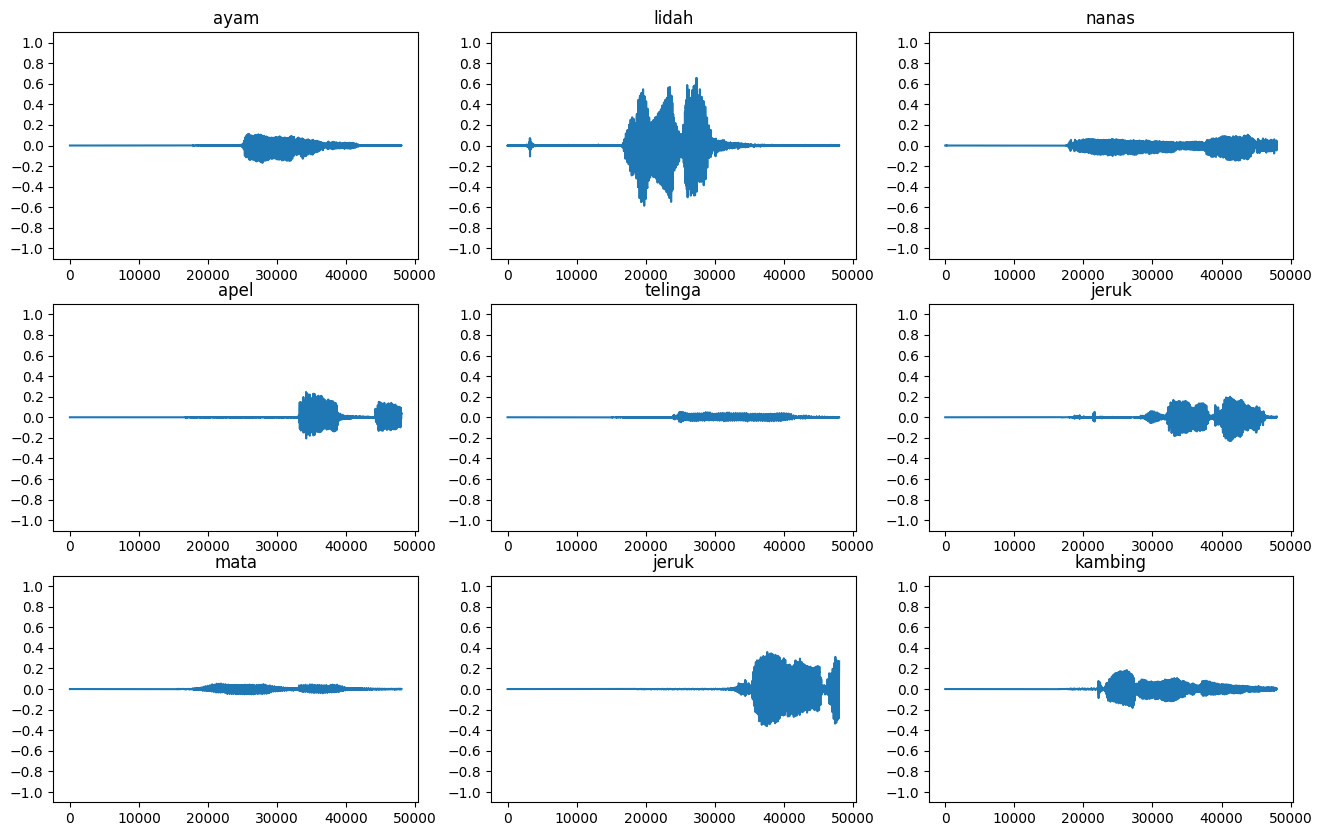

In [11]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, we'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when converting them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square.
- The STFT produces an array of complex numbers representing magnitude and phase. However, we only use the magnitude, which it can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [12]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [13]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=48000))

Label: ayam
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Label: lidah
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Label: nanas
Waveform shape: (48000,)
Spectrogram shape: (374, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

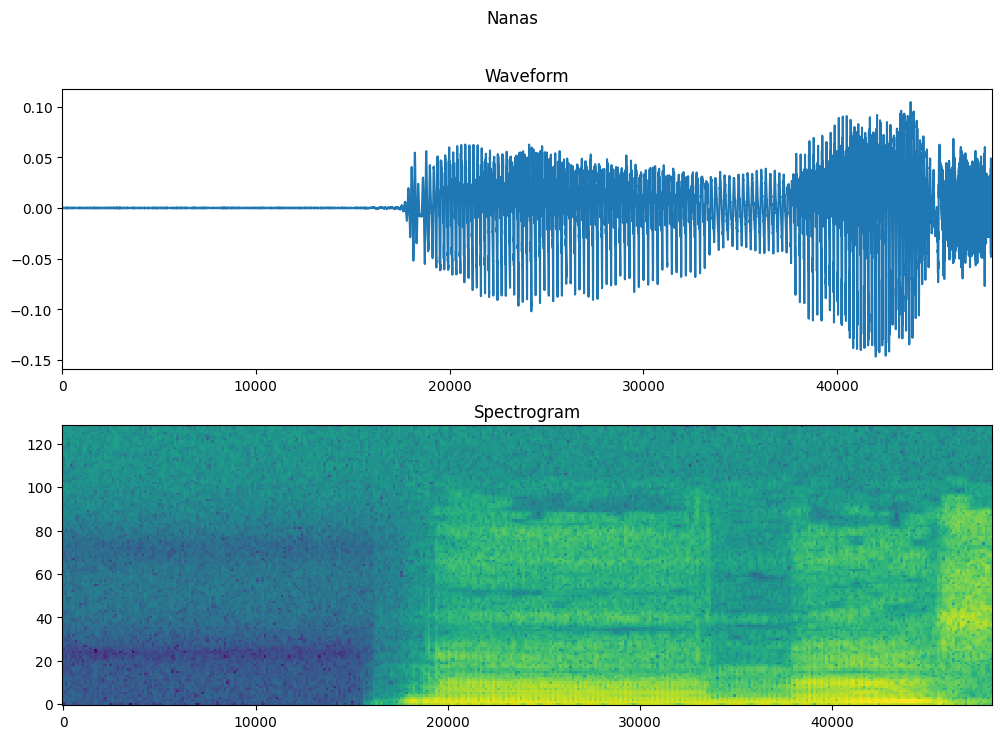

In [19]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 48000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [20]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [22]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

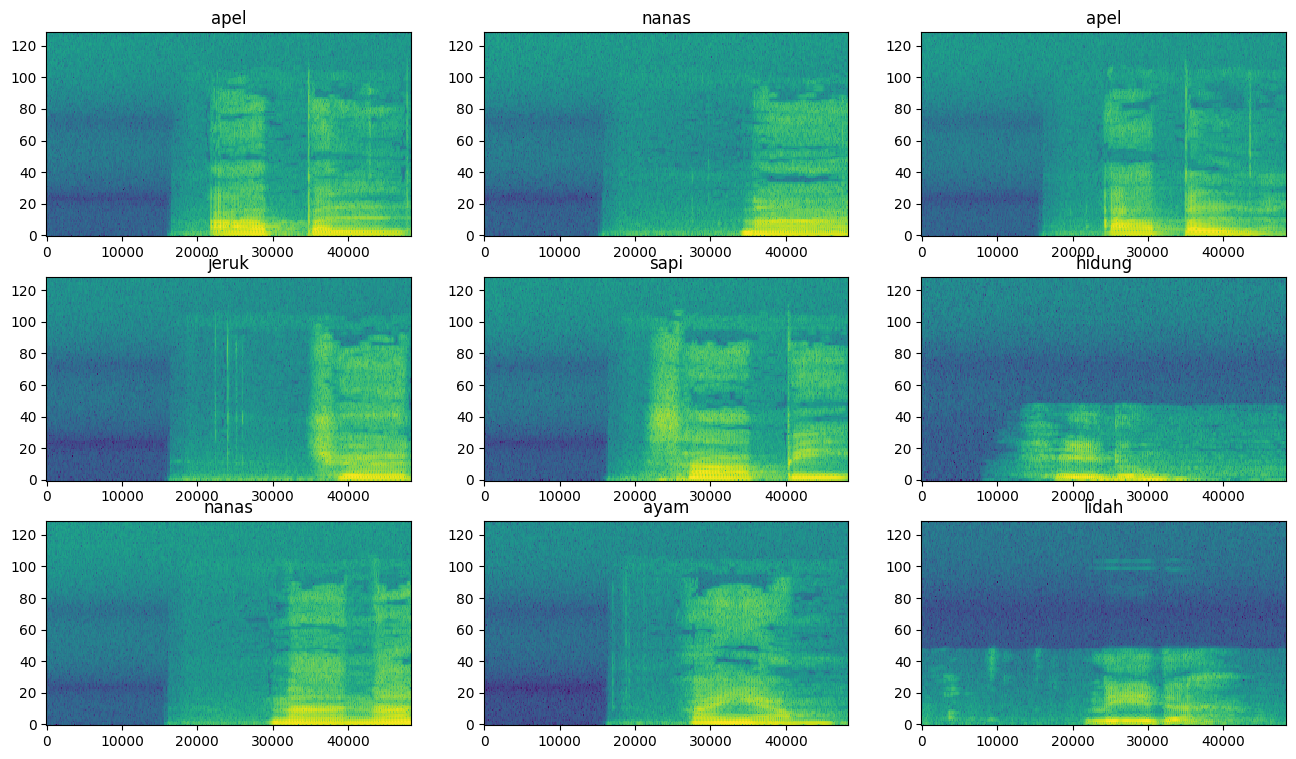

In [23]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [24]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, we'll use a simple convolutional neural network (CNN), since we have transformed the audio files into spectrogram images.

`tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

`Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [26]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Normalize.
    norm_layer,
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(374, 129, 1)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Input shape: (374, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 374, 129, 1)      3         
 ion)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 372, 127, 16)      160       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 186, 63, 16)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 184, 61, 32)       4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 92, 30, 32)       0         
 2D)                                                             
                           

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [28]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/50
19/19 [==============================] - 13s 108ms/step - loss: 2.5507 - accuracy: 0.1383 - val_loss: 2.2757 - val_accuracy: 0.2344
Epoch 2/50
19/19 [==============================] - 1s 33ms/step - loss: 2.0003 - accuracy: 0.3800 - val_loss: 1.5192 - val_accuracy: 0.5625
Epoch 3/50
19/19 [==============================] - 1s 33ms/step - loss: 1.3542 - accuracy: 0.5950 - val_loss: 1.1778 - val_accuracy: 0.6875
Epoch 4/50
19/19 [==============================] - 1s 35ms/step - loss: 1.0575 - accuracy: 0.6900 - val_loss: 0.8390 - val_accuracy: 0.7969
Epoch 5/50
19/19 [==============================] - 1s 35ms/step - loss: 0.8242 - accuracy: 0.7733 - val_loss: 0.8336 - val_accuracy: 0.8125
Epoch 6/50
19/19 [==============================] - 1s 34ms/step - loss: 0.6134 - accuracy: 0.8217 - val_loss: 0.7354 - val_accuracy: 0.8125
Epoch 7/50
19/19 [==============================] - 1s 34ms/step - loss: 0.5936 - accuracy: 0.8333 - val_loss: 0.8191 - val_accuracy: 0.8438
Epoch 8/50


Let's plot the training and validation loss curves to check how our model has improved during training:

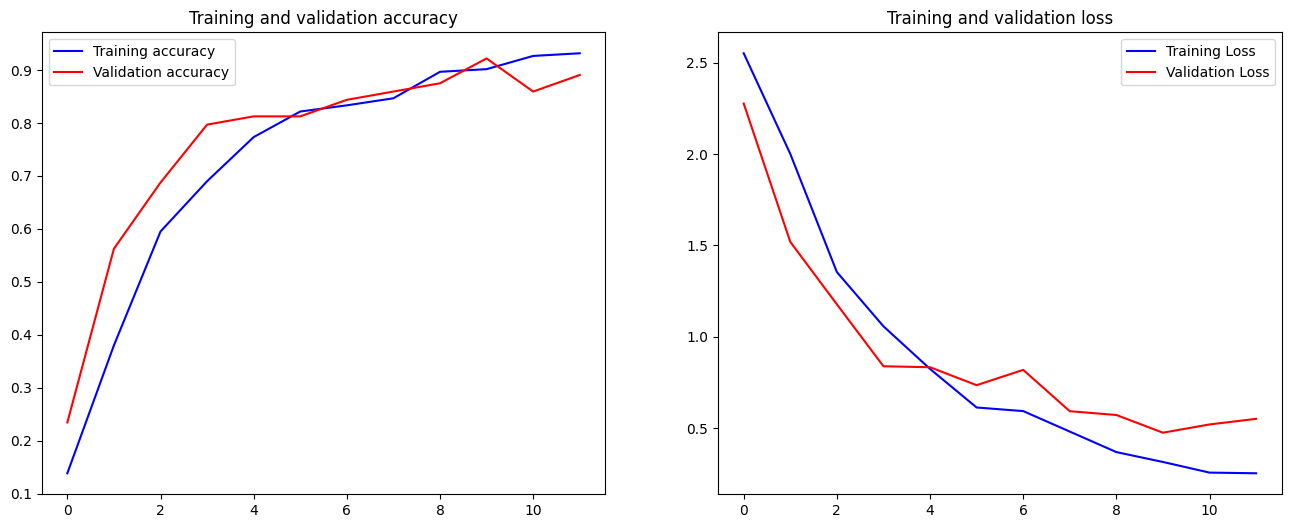

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [30]:
model.evaluate(test_spectrogram_ds, return_dict=True)

3/3 [==============================] - 1s 277ms/step - loss: 0.3349 - accuracy: 0.9070


{'loss': 0.3349093198776245, 'accuracy': 0.9069767594337463}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [31]:
y_pred = model.predict(test_spectrogram_ds)

3/3 [==============================] - 0s 8ms/step


In [32]:
y_pred = tf.argmax(y_pred, axis=1)

In [33]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

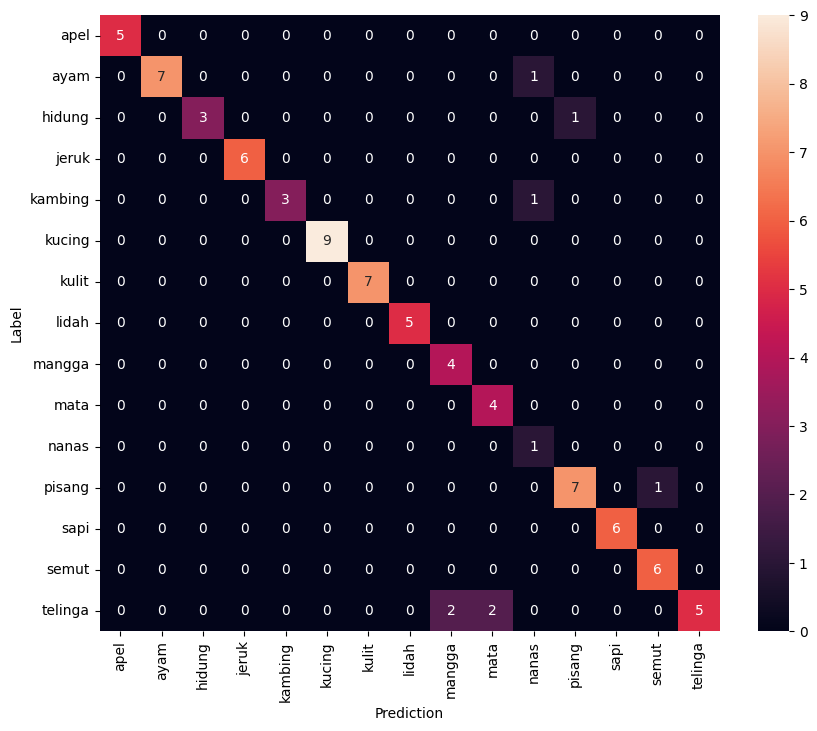

In [34]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "kucing".

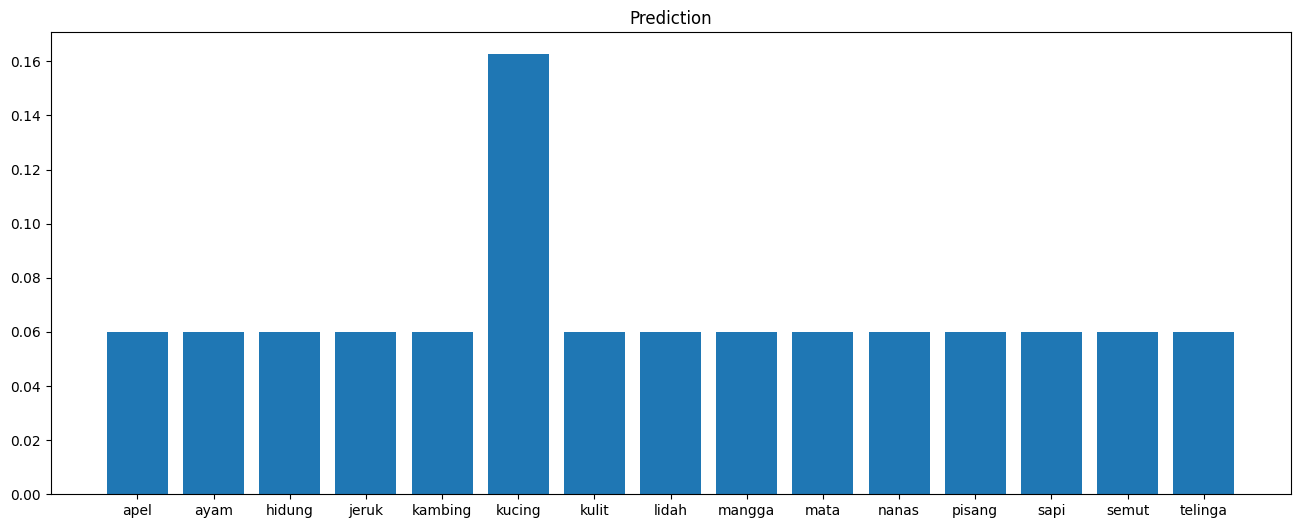

In [35]:
x = data_dir/'kucing/Perekaman baru 10.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=48000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['apel', 'ayam', 'hidung', 'jeruk', 'kambing', 'kucing', 'kulit', 'lidah',
 'mangga', 'mata', 'nanas', 'pisang', 'sapi', 'semut', 'telinga']
plt.figure(figsize=(16,6))
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Prediction')
plt.show()

display.display(display.Audio(waveform, rate=48000))

## Save the Model using model.save

In [36]:
model.save('model_baru.h5')

## Convert Using TFLite's Converter

In [37]:
# Select mode of optimization
mode = "Speed"

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [38]:
# Load your trained model
model = tf.keras.models.load_model('model_baru.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model_baru.tflite', 'wb') as f:
  f.write(tflite_model)

## Test using Tensorflow Interpreter

In [39]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="model_baru.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

1 input(s):
[  1 374 129   1] <class 'numpy.float32'>

1 output(s):
[ 1 15] <class 'numpy.float32'>


In [40]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_detail = interpreter.get_input_details()
output_detail = interpreter.get_output_details()

In [41]:
# Test model on random input data.
input_shape = input_detail[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_detail[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_detail[0]['index'])
print(output_data)

[[0.0000000e+00 1.6230588e-14 0.0000000e+00 7.1122875e-27 2.3730400e-34
  0.0000000e+00 0.0000000e+00 0.0000000e+00 2.1809080e-26 0.0000000e+00
  4.8125848e-10 5.6573197e-26 1.0000000e+00 4.1276178e-25 6.2485830e-24]]
